# Pre-Task

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import pickle

# Parameters

In [2]:
sequence_length = 10 # 원하는 sequence_length 설정
batch_size = 36 # 원하는 batch_size 설정 >> 6시간 기준
hidden_size = 16 # 원하는 hidden_size 설정
input_size = 11 # 사용하는 feature의 수

# Dataset

In [3]:
# df = pd.read_csv('../../data/Rail_data.csv')
df = pd.read_csv('../../data/Rail_data.csv')

# scaler = MinMaxScaler()
# scaled_col = ['air_temp','TSI','azimuth','altitude','solar_rad','High_solar_rad', 'casi', 'humidity', 'rain', 'wind_speed','wind_direction','rail_direction']
# df[scaled_col]= scaler.fit_transform(df[scaled_col])

# scaler1 = MinMaxScaler()
# df['rail_temp'] = scaler1.fit_transform(df['rail_temp'].values.reshape(-1,1))

df = df.astype({'solar_rad': 'float64'})
df = df.astype({'High_solar_rad': 'float64'})
df = df.astype({'casi': 'float64'})
df = df.astype({'humidity': 'float64'})
df = df.astype({'wind_speed': 'float64'})
df = df.drop(['rail_direction'], axis=1)
# int type >> float type

X = df.iloc[:,:11].values
y = df.iloc[:,11].values


def sequence_data(X,y, sequence_size): # 원하는 sequence에 따라 데이터 분리
    x_seq = []
    y_seq = []
    for idx in range(len(X) - sequence_size): #len(X)가 7000이고 seq_size가 5라면?
        x_seq.append(X[idx:idx + sequence_size]) # sequence_lengh개씩 특성들을 모두 묶음 >> shape: 5, 11
        y_seq.append(y[idx + sequence_size])     # x에 따른 온도들을 묶음 >> shape: 5, 1
        
    return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).view(-1,1)


X_seq, y_seq = sequence_data(X, y, sequence_length) # 원하는 sequence_length에 따라 데이터 묶기

X_train, X_test = X_seq[:int(len(X_seq)*0.7)], X_seq[int(len(X_seq)*0.7):]
y_train, y_test = y_seq[:int(len(y_seq)*0.7)], y_seq[int(len(y_seq)*0.7):]

train_DS = TensorDataset(X_train, y_train)
test_DS = TensorDataset(X_test, y_test)

train_DL = DataLoader(train_DS, batch_size = batch_size)
test_DL = DataLoader(test_DS, batch_size = batch_size)
# batch_size에 따라 데이터 처리

C:\Users\AML2\AppData\Local\Temp\ipykernel_20220\66687605.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).view(-1,1)


In [4]:
data = next(iter(train_DL))
seq, target = data[0], data[1]
target = target[int(len(target)*0.5):] 

data1 = next(iter(test_DL))
seq1, target1 = data1[0], data1[1]

print(seq.shape)
print(target.shape)
print(seq1.shape)
print(target1.shape)

print(y_seq.shape)
print(X_seq.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([72, 10, 11])
torch.Size([36, 1])
torch.Size([72, 10, 11])
torch.Size([72, 1])
torch.Size([96382, 1])
torch.Size([96382, 10, 11])
torch.Size([67467, 10, 11])
torch.Size([28915, 10, 11])
torch.Size([67467, 1])
torch.Size([28915, 1])


# Model

In [5]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        
        self.LSTM = nn.LSTM(input_size, hidden_size, batch_first=True).to(self.device)
        # hidden_size를 가진 hidden_state 출력
        
    def forward(self, x): 
        _, enc_hid = self.LSTM(x) 
        # hidden: 1, 36, 16(1, batch, hidden_size) >> (1, 16)짜리가 36개(각각의 state마다의 hidden_state를 포함)
        
        return enc_hid
    
        
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, device):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first=True).to(self.device)
        
    def forward(self, x):
        _, dec_hid = self.LSTM(x)
     
        return dec_hid
        
        # prediction을 다시 input으로 decoder 투입
        # prediction이 input으로 들어가서 다시 attention한 후에 next prediction을 출력
        # attention 후에 decoder 내부에서 기존의 attention처럼 진행하는 것이 가능한가?
        # prediction의 hidden_state를 이용해서 next prediction을 하는 것이 예측에 도움을 줄 수 있는가? 
        
class Attention(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, device):
        super(Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.device = device 
        self.encoder = LSTMEncoder(input_size, hidden_size, device).to(self.device)
        self.decoder = LSTMDecoder(hidden_size, device).to(self.device)
        
        self.to_query = nn.Linear(hidden_size, hidden_size).to(self.device)
        self.to_key = nn.Linear(hidden_size, hidden_size).to(self.device)
        self.to_value = nn.Linear(hidden_size, hidden_size).to(self.device)
        
        
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first = True).to(self.device)
        self.fc = nn.Linear(input_size, hidden_size)
        self.fc0 = nn.Linear(hidden_size * 2, hidden_size)
        # hidden * 2 >> Concatenated hidden, hidden >> original hidden
        self.fc1 = nn.Linear(sequence_length * hidden_size, 1)    
        
    def forward(self, x):
        # enc_x, dec_x로 나누기
        enc_x, dec_x = x[:int(len(x)*0.5)], x[int(len(x)*0.5):] 
        
        _, enc_hid = self.encoder(enc_x)
        
        
        enc_hid = torch.tensor(enc_hid)
        
        
        dec_input = self.fc(dec_x)
        # 36, 10, 16
        
        for _ in range(sequence_length):
            
            _, dec_hid = self.decoder(dec_input)
            
            query = self.to_query(dec_hid) # 1, batch, hidden_size   
            key = self.to_key(enc_hid)  # 1, batch, hidden_size
            value = self.to_value(enc_hid) # 1, batch, hidden_size
            
            query = query.permute(1, 2, 0).contiguous() # batch, hidden_size, 1
            key = key.permute(1, 0, 2).contiguous() # batch, 1, hidden_size
            value = value.permute(1, 2, 0).contiguous() # batch, hidden_size, 1
            
            
            attention_score = query @ key # batch, hidden_size, 1 @ batch, 1, hidden_size
            attention_score = attention_score.softmax(dim = -1) # batch, hidden_size, hidden_size

            attention_value = attention_score @ value # batch, hidden_size, 1
            # hidden_size, hidden_size @ hidden_size, 1 >> hidden_size,1
            attention_value = attention_value.permute(2, 0, 1).contiguous() # 1, batch, hidden_size
            
            new_hidden = torch.tanh(self.fc0(torch.cat((attention_value, dec_hid),dim=2))) # 1, batch, hidden_size
            cell_state = torch.zeros_like(new_hidden)
            
            out, _  = self.LSTM(dec_input, (new_hidden, cell_state)) # batch, sequence_length, hidden_size
            out = out.reshape(out.shape[0], -1) # batch, sequence_length * hidden_size
            out = self.fc1(out) # batch, 1
            
            # dec_input = out.unsqueeze(1) # batch, 1, 1
            # dec_input = dec_input.repeat(1, hidden_size, 1) # batch, hidden_size, 1
            # dec_input = dec_input.permute(0, 2, 1).contiguous()
            # dec_input = dec_input.repeat(1, sequence_length, 1) # batch, sequence_length, hidden_size
            
            
        return out

# Train

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu 활성화 확인
model = Attention(input_size, hidden_size, sequence_length, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

loss_graph = []
n = len(train_DL)

for epoch in range(200):
    running_loss = 0
    for data in train_DL:
        seq, target = data[0].to(device), data[1].to(device)
        target = target[int(len(target)*0.5):] 
        
        
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_graph.append(running_loss/n)
    if epoch % 50 == 0:
        print("[epoch: %d] loss : %.4f" %(epoch,running_loss/n))
       



C:\Users\AML2\AppData\Local\Temp\ipykernel_20220\93015793.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc_hid = torch.tensor(enc_hid)


[epoch: 0] loss : 510.7858
[epoch: 50] loss : 48.7384
[epoch: 100] loss : 23.5550
[epoch: 150] loss : 18.5164


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu 활성화 확인
model = Attention(input_size, hidden_size, sequence_length, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

loss_graph = []
n = len(train_DL)

for epoch in range(1000):
    running_loss = 0
    for data in train_DL:
        seq, target = data[0].to(device), data[1].to(device)
        target = target[int(len(target)*0.5):] 
        
        
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_graph.append(running_loss/n)
    if epoch % 50 == 0:
        print("[epoch: %d] loss : %.4f" %(epoch,running_loss/n))
       



C:\Users\AML2\AppData\Local\Temp\ipykernel_7016\93015793.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc_hid = torch.tensor(enc_hid)


[epoch: 0] loss : 521.5845
[epoch: 50] loss : 49.5351
[epoch: 100] loss : 35.5110
[epoch: 150] loss : 25.6789
[epoch: 200] loss : 18.9078
[epoch: 250] loss : 14.7053
[epoch: 300] loss : 12.3734
[epoch: 350] loss : 12.8232
[epoch: 400] loss : 9.3635
[epoch: 450] loss : 9.4031
[epoch: 500] loss : 8.2571
[epoch: 550] loss : 8.6588
[epoch: 600] loss : 8.6052
[epoch: 650] loss : 8.2544
[epoch: 700] loss : 6.7696
[epoch: 750] loss : 6.0949
[epoch: 800] loss : 6.1649
[epoch: 850] loss : 4.8717
[epoch: 900] loss : 4.7959
[epoch: 950] loss : 4.8786


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #gpu 활성화 확인
model = Attention(input_size, hidden_size, sequence_length, device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

loss_graph = []
n = len(train_DL)

for epoch in range(2000):
    running_loss = 0
    for data in train_DL:
        seq, target = data[0].to(device), data[1].to(device)
        target = target[int(len(target)*0.5):] 
        
        
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_graph.append(running_loss/n)
    if epoch % 50 == 0:
        print("[epoch: %d] loss : %.4f" %(epoch,running_loss/n))
       



C:\Users\AML2\AppData\Local\Temp\ipykernel_20424\93015793.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc_hid = torch.tensor(enc_hid)


[epoch: 0] loss : 509.5148
[epoch: 50] loss : 53.7861
[epoch: 100] loss : 30.3107
[epoch: 150] loss : 22.4300
[epoch: 200] loss : 18.7453
[epoch: 250] loss : 12.9696
[epoch: 300] loss : 11.7771
[epoch: 350] loss : 11.1884
[epoch: 400] loss : 9.8067
[epoch: 450] loss : 9.2915
[epoch: 500] loss : 7.3800
[epoch: 550] loss : 8.0401
[epoch: 600] loss : 6.3945
[epoch: 650] loss : 6.4099
[epoch: 700] loss : 6.1262
[epoch: 750] loss : 8.1915
[epoch: 800] loss : 5.1858
[epoch: 850] loss : 5.1770
[epoch: 900] loss : 5.1161
[epoch: 950] loss : 5.1120
[epoch: 1000] loss : 4.7261
[epoch: 1050] loss : 4.0961
[epoch: 1100] loss : 4.3663
[epoch: 1150] loss : 4.0389
[epoch: 1200] loss : 3.7739
[epoch: 1250] loss : 4.1825
[epoch: 1300] loss : 3.8739
[epoch: 1350] loss : 4.7015
[epoch: 1400] loss : 3.5838
[epoch: 1450] loss : 3.3624
[epoch: 1500] loss : 3.7553
[epoch: 1550] loss : 3.9541
[epoch: 1600] loss : 3.5678
[epoch: 1650] loss : 3.4403
[epoch: 1700] loss : 3.3305
[epoch: 1750] loss : 3.6057
[epoch

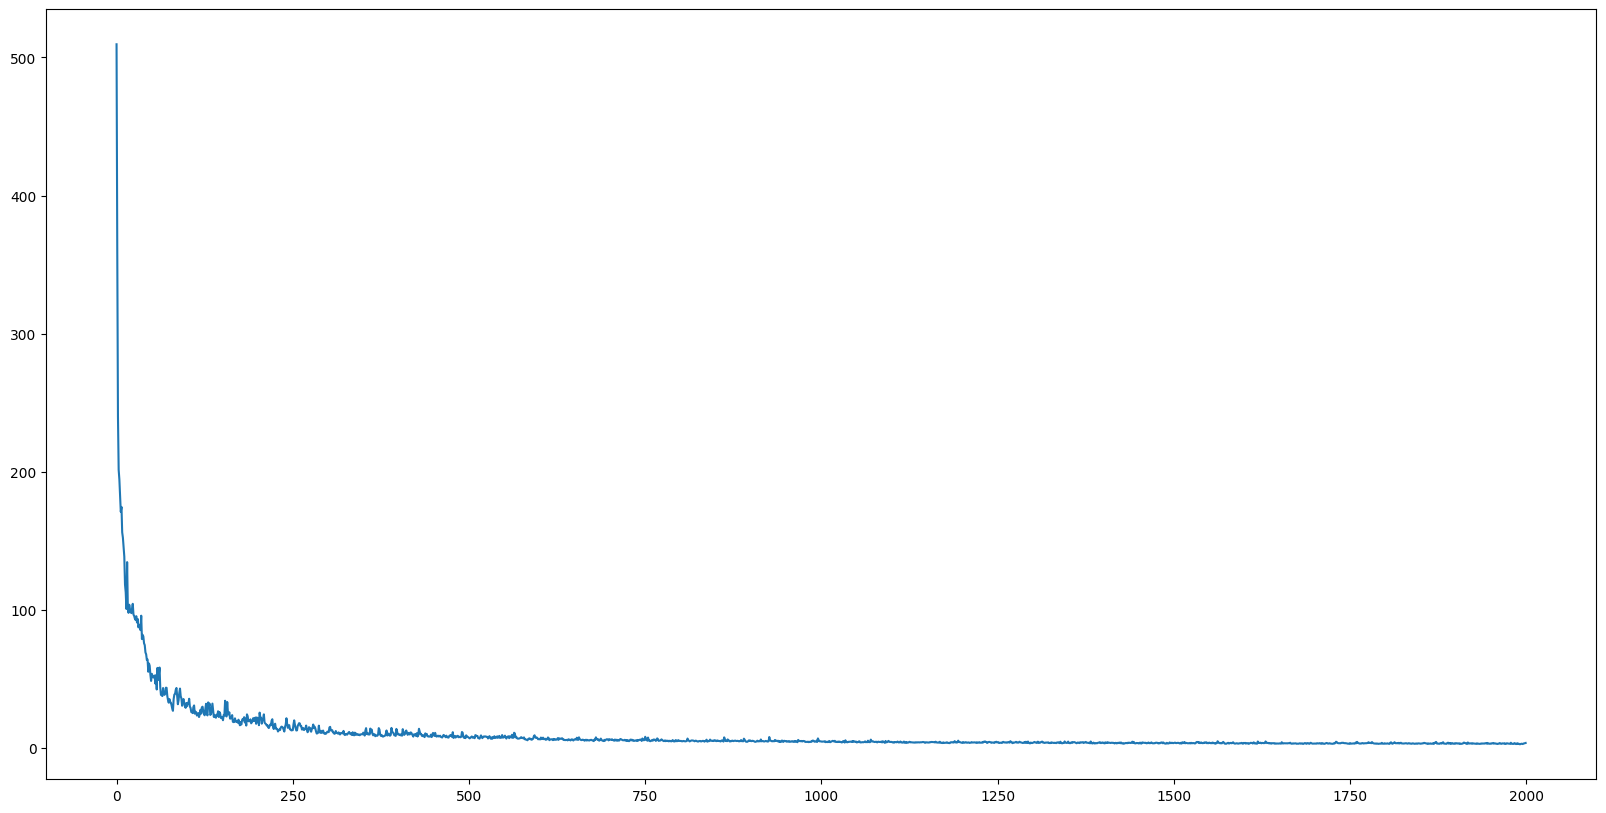

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

# Test

In [9]:
concatdata = torch.utils.data.ConcatDataset([train_DS, test_DS])
data_loader = DataLoader(dataset=concatdata, batch_size = batch_size)


model.eval()
with torch.no_grad():
    pred = [] 
    for data in data_loader:
        seq, target = data[0].to(device), data[1].to(device)
        
        out = model(seq)
        pred += out.cpu().tolist()

C:\Users\AML2\AppData\Local\Temp\ipykernel_20220\93015793.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc_hid = torch.tensor(enc_hid)


In [11]:
print(len(pred)) # 내부로 들어가서 반만 이용하는 모델의 방식 때문에 뒷부분 반만 출력값이 존재

48191


# Evaluation

In [14]:
# with open('Attention_0.pkl', 'wb')as file:
#     pickle.dump(model, file)
    
# with open('Attention_0.pkl', 'rb')as file:
#     Attention_0=pickle.load(file)
    

print("Attention_Model_Evaluation")

# print("r2_score(train):", r2_score(y_train, pred[:int(len(pred)*0.7)]))
print("r2_score(test):", r2_score(y_test, pred[int(len(pred)*0.4):]))

# print("mae(train):", mean_absolute_error(y_train, pred[:int(len(y_seq)*0.7)]))
print("mae(test):", mean_absolute_error(y_test, pred[int(len(pred)*0.4):] ))

# print("rmse(train):", mean_squared_error(y_train, pred[:int(len(y_seq)*0.7)] )**0.5)
print("rmse(test):", mean_squared_error(y_test, pred[int(len(pred)*0.4):] )**0.5)

Attention_Model_Evaluation
r2_score(test): -1.42822842055809
mae(test): 17.919453490611932
rmse(test): 21.79021761902615
